In [1]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pickle
from io import StringIO
from utils import *
import sys
sys.path.append("/home/ubuntu/vdp-tool-chain-repo/utils")
from common import pz_partition, read_pickle, yolo_pzname_to_name
from train_clevr import VAE
from train_puzzles import PrototypeVAE
import itertools
from tqdm.auto import tqdm
device = torch.device("cuda:0")
# sns.set()

In [2]:
train_on = list(filter(lambda x: not x[1] , pz_partition.keys()))
images = VDPImage("../data/clevr-cleaned-variants", to_run)
# training_idxs = list(itertools.chain(*[list(range(l, h + 1)) for l, h in map(lambda x : pz_partition[x], train_on)]))
training_idxs = list(range(0, 825))
allpuzzles = torch.utils.data.Subset(images, training_idxs)
allpuzzles = DataLoader(allpuzzles, batch_size=1)



In [3]:
# set([os.path.basename(os.path.dirname(pth[0])) for (x, y, pth) in (allpuzzles)])


In [45]:
height = 320
model_str = f"again-cifar-puzzle-prototype-net-320-epoch=23-accuracy=0.60"
model_vae = VAE(height).from_pretrained("cifar10-resnet18")
# model_vae = model_vae.load_from_checkpoint(f"../data/prototype/puzzle-pretrained-vae-320-final.ckpt", strict=False, input_height=height)
model = PrototypeVAE(model_vae)
model = model.load_from_checkpoint(f"../data/prototype/{model_str}.ckpt", strict=False, vae_model=model_vae)
model = model.to(device)

In [46]:
# with the vae pretraining

vae_preds = list()
tqdmiter = tqdm(allpuzzles)
for (x, y, pth) in tqdmiter:
    pred = model.forward_naive((x.to(device).squeeze(), y.to(device)))
    vae_preds.append((pth, y[0][pred.item()] == 0. ))
    # vae_preds.append((pth, torch.Tensor([True]) ))
    tqdmiter.set_description(f"Accuracy: {sum(map(lambda x: x[1], vae_preds) ) / len(vae_preds)}")

sum(map(lambda x: x[1], vae_preds) ) / len(vae_preds)


  0%|          | 0/825 [00:00<?, ?it/s]

tensor(0.3867)

In [60]:
# cleaned_vae_preds = [(os.path.basename(os.path.dirname(x[0])), os.path.basename(x[0]), x[0], y.item()) for (x, y) in vae_preds]
# with open(f"{model_str}-results.pkl", "wb") as fp:
#     pickle.dump(cleaned_vae_preds, fp)
model_str = "cifar-puzzle-prototype-net-320-final"
cleaned_vae_preds = read_pickle(f"{model_str}-results.pkl")

vae_df = pd.DataFrame(cleaned_vae_preds, columns=['puzzle_name', 'variant', 'pth', 'is_correct'])
vae_df['pth'] = vae_df['pth'].str.replace("../data", "data")

vae_df.head()

vae_df['is_correct'].mean()


/home/ubuntu/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


0.3927272727272727

In [50]:

# preds = list()
# tqdmiter = tqdm(allpuzzles)
# for (x, y, pth) in tqdmiter:
#     pred = model.forward_naive((x.to(device).squeeze(), y.to(device)))
#     preds.append((pth, y[0][pred.item()] == 0. ))
#     # preds.append((pth, torch.Tensor([True]) ))
#     tqdmiter.set_description(f"Accuracy: {sum(map(lambda x: x[1], preds) ) / len(preds)}")

# sum(map(lambda x: x[1], preds) ) / len(preds)

# # $ 40.2 % before new loss

In [51]:
# cleaned_preds = [(os.path.basename(os.path.dirname(x[0])), os.path.basename(x[0]), x[0], y.item()) for (x, y) in preds]
# # with open(f"{model_str}-results.pkl", "wb") as fp:
# #     pickle.dump(cleaned_preds, fp)

# df = pd.DataFrame(cleaned_preds, columns=['puzzle_name', 'variant', 'pth', 'is_correct'])
# df['pth'] = df['pth'].str.replace("../data", "data")

# df.head()

In [61]:
with open("baseline_solver_preds.pkl", "rb") as fp:
    baseline_solver_preds = pickle.load(fp)
bs_df = pd.DataFrame(baseline_solver_preds, columns=["puzzle_name", "variant", "pth", "baseline", "solver"])
bs_df['baseline'] = (bs_df['baseline'] == 0)
bs_df['solver'] = (bs_df['solver'] == 0)
bs_df.head()

,puzzle_name,variant,pth,baseline,solver
0,apocope,fovariant-5-swap5,data/clevr-cleaned-variants/apocope/fovariant-...,False,True
1,apocope,fovariant-1,data/clevr-cleaned-variants/apocope/fovariant-1,False,True
2,apocope,fovariant-0,data/clevr-cleaned-variants/apocope/fovariant-0,True,True
3,apocope,fovariant-16-swap4,data/clevr-cleaned-variants/apocope/fovariant-...,False,True
4,apocope,fovariant-8,data/clevr-cleaned-variants/apocope/fovariant-8,True,True


In [62]:
results = vae_df.merge(bs_df, on='pth')

assert all(results['puzzle_name_x'] == results['puzzle_name_y'])
assert all(results['variant_x'] == results['variant_y'])

results['count'] = results.groupby(['puzzle_name_x'])['variant_x'].transform("count")
results['indexlabel'] = results.apply(lambda row: f"{row.name}", axis=1)
results['xlabel'] = results.apply(lambda row: f"{row['puzzle_name_x']}\n(N={row['count']})", axis=1)
results.groupby("puzzle_name_x")['is_correct'].count().reset_index()


,puzzle_name_x,is_correct
0,agreement,25
1,alternate-color,25
2,alternation,100
3,aphaeresis,25
4,apocope,75
5,assimilation,100
6,breaking,50
7,circle-at-ends,50
8,devoicing,50
9,meeussen,25


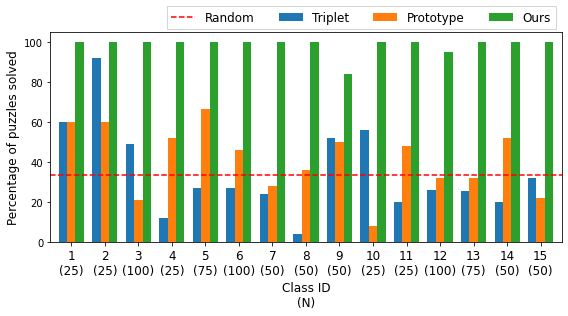

In [378]:
# sns.set()
result = results[['xlabel', 'count', 'indexlabel', 'variant_x', 'baseline', 'solver', 'is_correct']].rename(columns={
                                                                                    'xlabel':'puzzle_name',
                                                                                    'indexlabel' : 'pz_number',
                                                                                    'variant_x':'variant',
                                                                                    'is_correct':'Prototype',
                                                                                    'count' : 'count',
                                                                                    'baseline':'Triplet',
                                                                                    'solver':'Ours',
})


fig = plt.figure(figsize=(8, 4.5), tight_layout=True)
ax = fig.add_subplot(111)

barcont = (result.groupby(['puzzle_name'])[['Triplet', 'Prototype', 'Ours']].mean() * 100) .plot.bar(ax=ax, width=0.75 )
ax.axhline(33.33, linestyle='--', color='red', label='Random')
# plt.text(15.05, 33.33, "random", c="r", ha="right", va='center', alpha=1)
# ax.annotate('average',(-0.4,23.5))
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.15),
          ncol=4, fancybox=False, shadow=False, fontsize=12)

# ax.set_xticklabels(result.groupby(['puzzle_name']).mean().index)

# bar1 = plt.bar(np.arange(len(errorRateListOfFast)) + bar_width, errorRateListOfFast, bar_width, align='center', alpha=opacity, color='b', label='Fast <= 6 sec.')

# Add counts above the two bar graphs
count_puzzles= result.groupby(['puzzle_name'])['count'].max().tolist()
# print()
# max_height = max([rect.get_height() for rect in barcont.containers[2]])
# for i, rect in enumerate(barcont.containers[1]):
#     # height = rect.get_height()
#     plt.text(rect.get_x() + rect.get_width() / 2.0, max_height + 0.1, f'N= {count_puzzles[i]}', ha='center', va='bottom', c='dimgray', fontsize=7)

# plt.text(-1.5, -12.5, "N= ", ha="left", va='bottom', alpha=1, fontsize=12)

labels = list(map(lambda i : str(i + 1) + f"\n({count_puzzles[i]})" , range(len(result.groupby(['puzzle_name']).mean().index))))
ax.set_xticklabels(labels, fontsize=12)
plt.xticks(rotation=0, ha='center')
plt.xlabel("Class ID\n(N)", fontsize=12)
plt.ylabel("Percentage of puzzles solved", fontsize=12)
# plt.title("Percent puzzle variants solved when target candidate is identified correctly", loc='left')
plt.savefig("barplot.pgf")

In [2]:
natscene_df = pd.read_csv(StringIO("""index|puzzle|Intended|Unintended|incorrect
19|2on1| 53.0 | 11.333333333333343 | 35.666666666666664
16|allcatsonsofas| 36.0 | 18.333333333333343 | 45.666666666666664
13|desktop| 95.33333333333333 | 4.666666666666671 | 0.0
8|dogherded| 88.75 | 11.25 | 0.0
17|kitchen| 45.5 | 17.5 | 37.0
20|catontv| 33.333333333333336 | 26.666666666666657 | 40.0
14|pplwearingties| 28.333333333333332 | 19.33333333333333 | 52.333333333333336
18|tvon| 0.0 | 0.3333333333333286 | 99.66666666666667
10|umbrella| 52.083333333333336 | 12.916666666666657 | 35.0
12|alldogsonsofas| 14.583333333333334 | 68.75 | 16.666666666666668
9|parkmeter| 100.0 | 0.0 | 0.0
7|personball| 100.0 | 0.0 | 0.0
11|populatedbus| 55.0 | 20.0 | 25.0
15|sleeping| 71.66666666666667 | 11.666666666666657 | 16.666666666666668
5|middleball| 10.0 | 0.0 | 90.0
4|separatepiles| 50.0 | 0.0 | 50.0
2|truck| 100.0 | 0.0 | 0.0
3|drivingdirection| 100.0 | 0.0 | 0.0
1|allteddysonsofas| 87.33333333333333 | 12.666666666666671 | 0.0
6|setplates| 50.666666666666664 | 17.66666666666667 | 31.666666666666668"""), sep="|").set_index('index')

pz_cnt = pd.read_csv(StringIO("""puzzle:count
2on1:300
allcatsonsofas:300
alldogsonsofas:48
catontv:120
desktop:300
dogherded:240
kitchen:200
parkmeter:120
personball:200
populatedbus:60
pplwearingties:300
sleeping:240
umbrella:240
separatepiles:80
truck:48
drivingdirection:48
middleball:120
allteddysonsofas:300
setplates:300
tvon:300"""), sep=":")

natscene_df = natscene_df.merge(pz_cnt, on='puzzle')


natscene_df['puzzle_name'] = natscene_df['puzzle'].map(yolo_pzname_to_name)
# natscene_df['puzzle_name']

# natscene_df[['Intended', 'Unintended']].sort_index().reset_index().plot.bar()
natscene_df#.groupby('puzzle').count()

,puzzle,Intended,Unintended,incorrect,count,puzzle_name
0,2on1,53.000000,11.333333,35.666667,300,2 cats on 1 couch
1,allcatsonsofas,36.000000,18.333333,45.666667,300,All cats on sofas
2,desktop,95.333333,4.666667,0.000000,300,Desktop
3,dogherded,88.750000,11.250000,0.000000,240,Dog Herding
4,kitchen,45.500000,17.500000,37.000000,200,Kitchen
5,catontv,33.333333,26.666667,40.000000,120,Cat on TV
6,pplwearingties,28.333333,19.333333,52.333333,300,People wearing ties
7,tvon,0.000000,0.333333,99.666667,300,Television switched on
8,umbrella,52.083333,12.916667,35.000000,240,Umberella
9,alldogsonsofas,14.583333,68.750000,16.666667,48,All dogs on sofas


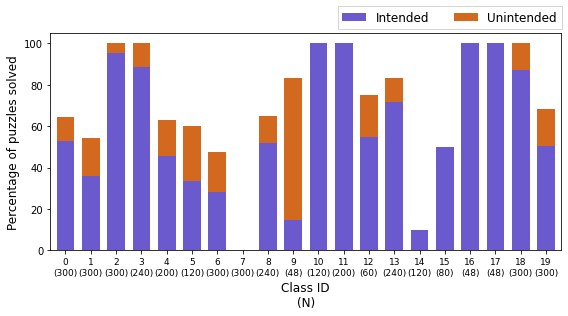

In [17]:
fig = plt.figure(figsize=(8, 4.5), tight_layout=True)
ax = fig.add_subplot(111)
barcont = natscene_df[['Intended', 'Unintended']].sort_index().plot(kind='bar', width=0.7, stacked=True, ax=ax, color=['slateblue', "chocolate"])


ax.legend(loc='upper right', bbox_to_anchor=(1.0125, 1.15),
          ncol=3, fancybox=False, shadow=False, prop=dict(size=12))


counts = natscene_df['count'].sort_index().tolist()
# count_puzzles= natscene_df['count'].max().tolist()
# max_height = max([rect.get_height() for rect in barcont.containers[0]])
# for i, rect in enumerate(barcont.containers[1]):
#     height = barcont.containers[1][i].get_height() + barcont.containers[0][i].get_height()
#     plt.text(rect.get_x() + rect.get_width() / 2.0, height + 0.1, f'N=50', ha='center', va='bottom', c='dimgray',)

labels = list(map(lambda i : i + f"\n({counts[int(i)]})",  map(lambda i: i.get_text(), ax.get_xticklabels()) ))
ax.set_xticklabels(labels)
plt.xticks(rotation=0, ha='center', fontsize=9)
# plt.text(-1.5, -20, "N= ", ha="left", va='bottom', alpha=1)

plt.xlabel("Class ID\n(N)", fontsize=12)
plt.ylabel("Percentage of puzzles solved", fontsize=12)
# plt.show()
# sns.despine(left=False, bottom=False)
# plt.title("Title of this graph", loc='left')
# plt.ylabel("percent correct", horizontalalignment='left')
# plt.show()
# plt.tight_layout()
plt.savefig("stackedbarchart.pgf")

,puzzle,Intended,Unintended,incorrect,puzzle_name,count
0,2on1,53.000000,11.333333,35.666667,2 cats on 1 couch,300
1,allcatsonsofas,36.000000,18.333333,45.666667,All cats on sofas,300
2,desktop,95.333333,4.666667,0.000000,Desktop,300
3,dogherded,88.750000,11.250000,0.000000,Dog Herding,240
4,kitchen,45.500000,17.500000,37.000000,Kitchen,200
5,catontv,33.333333,26.666667,40.000000,Cat on TV,120
6,pplwearingties,28.333333,19.333333,52.333333,People wearing ties,300
7,tvon,0.000000,0.333333,99.666667,Television switched on,300
8,umbrella,52.083333,12.916667,35.000000,Umberella,240
9,alldogsonsofas,14.583333,68.750000,16.666667,All dogs on sofas,48


In [37]:
ooopreds = read_pickle("ooo_baseline_proto_preds.pkl")

ooo_df = pd.DataFrame(ooopreds, columns=['puzzle', 'puzzle_name', 'variant', 'shuffle', 'baseline', 'proto', 'solver'])

ooo_df_grouped = ooo_df.groupby(['puzzle_name'])[['baseline', 'proto', 'solver']].sum().reset_index()
ooo_df_grouped['baseline_perc'] = 100 * ooo_df_grouped['baseline'] / ooo_df_grouped['solver']
ooo_df_grouped['proto_perc'] = 100 * ooo_df_grouped['proto'] / ooo_df_grouped['solver']

ooo_df_grouped#['basleine_perc'] > 25.0

,puzzle_name,baseline,proto,solver,baseline_perc,proto_perc
0,agreement,14,38,100,14.000000,38.000000
1,alternate-color,19,46,175,10.857143,26.285714
2,alternation,21,9,75,28.000000,12.000000
3,aphaeresis,18,27,100,18.000000,27.000000
4,apocope,5,36,125,4.000000,28.800000
5,assimilation,27,40,200,13.500000,20.000000
6,breaking,0,21,150,0.000000,14.000000
7,circle-at-ends,7,6,50,14.000000,12.000000
8,devoicing,44,62,150,29.333333,41.333333
9,meeussen,2,4,15,13.333333,26.666667
